In [156]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer
from category_encoders import CountEncoder, LeaveOneOutEncoder, TargetEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import set_config
from sklearn.svm import SVR
import matplotlib.pyplot as plt
set_config(display='diagram')

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)
#df = df.drop('PropertyName', axis=1)

cat_attribs = ['BuildingType', 'PrimaryPropertyType','CouncilDistrictCode',
               'Neighborhood', 'ListOfAllPropertyUseTypes',
               'LargestPropertyUseType', 'PropertyName']

num_attribs = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
               'ENERGYSTARScore']

y = 'TotalGHGEmissions'

# Création d'un jeu d'entraînement et d'un jeu de test
train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train = train[cat_attribs + num_attribs]
y_train = train[y].values

# 1. Régression linéaire

In [3]:
model = LinearRegression()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder()),
    ])

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ])

preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA', 'Latitude',
                                  'Longitude', 'ENERGYSTARScore']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe', OneHotEncoder())]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'CouncilDistrictCode', 'Neighborhood',
                                  'ListOfAllPropertyUseTypes',
                                  'LargestPropertyUseType', 'PropertyName'])])

In [4]:
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
print("X_train_prepared shape: ", X_train_prepared.shape)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.946471,0.418654,2.434049,2.778540,2.943697,2.990571,3.585497
score_time,5.0,0.000400,0.000548,0.000000,0.000000,0.000000,0.000999,0.001001
test_score,5.0,590.584676,288.756162,225.075164,429.534559,553.148525,790.305424,954.859706
train_score,5.0,1.534266,0.327858,1.228615,1.255623,1.422413,1.837202,1.927478


Le modèle surajuste considérablement les données d'entraînement : l'écart entre le RMSE sur les données d'entraînement et sur les données de validation sont énormes. Voyons si les résultats s'améliore en ajoutant une étape de sélection de variables.

In [5]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=150, score_func=mutual_info_regression))
])

preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('feature_selection',
                 SelectKBest(k=150,
                             score_func=<function mutual_info_regression at 0x0000026DA2E42A60>))])

In [6]:
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.124478,0.023529,0.094687,0.108072,0.124694,0.146966,0.147972
score_time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
test_score,5.0,103.682466,12.232467,92.903389,94.165047,103.877330,103.994509,123.472057
train_score,5.0,97.271520,3.261664,91.997879,97.136326,97.297935,99.617541,100.307920


En sélectionnant __150 variables__ à l'aide de la classe `SelectKBest()`, il n'y a plus de problème de surajustement. l'écart entre le RMSE obtenu avec les données d'entraînement et de validation s'est nettement réduit.  

# 2. Lasso

Utilisons `preprocessing_pipeline` cette fois ci avec le modèle `Lasso()` : 

In [7]:
model = Lasso()

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
print("X_train_prepared shape: ", X_train_prepared.shape)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.277547,0.302751,1.840223,2.152942,2.279307,2.519179,2.596084
score_time,5.0,0.000401,0.000549,0.000000,0.000000,0.000000,0.001000,0.001005
test_score,5.0,108.375351,10.264733,98.194887,99.032817,110.393198,111.076181,123.179674
train_score,5.0,106.886027,2.752002,102.441357,106.598692,107.061436,109.015399,109.313251


RMSE moyen sur les jeux de validation : 108,37.

Utilisons à présent le transformateur `preprocessing_and_feature_selection_pipeline`, toujours avec le modèle `Lasso()` :

In [8]:
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.177880,0.015553,0.160438,0.165437,0.181627,0.182207,0.199692
score_time,5.0,0.000402,0.000551,0.000000,0.000000,0.000000,0.001002,0.001009
test_score,5.0,108.841638,10.337190,98.842289,99.179819,111.101184,111.314344,123.770551
train_score,5.0,107.392985,2.759705,102.928994,107.190910,107.481384,109.609284,109.754352


En rajoutant l'étape de sélection de variables, le RMSE moyen sur les jeux de validation se dégrade légèrement, passant de 108,38 à 108,84. 

# 3. SVR

In [86]:
model = SVR()

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
print("X_train_prepared shape: ", X_train_prepared.shape)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.070596,0.111622,0.921921,1.026612,1.040236,1.179983,1.184227
score_time,5.0,0.211987,0.013887,0.187496,0.214442,0.218498,0.218611,0.220891
test_score,5.0,138.062040,17.894452,124.833482,125.576164,131.222094,140.677693,168.000765
train_score,5.0,138.621107,4.722941,130.567189,138.481052,140.475603,141.156091,142.425601


In [88]:
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.306600,0.167286,1.007816,1.371949,1.371949,1.390643,1.390643
score_time,5.0,0.256238,0.045013,0.187498,0.249980,0.249980,0.296865,0.296865
test_score,5.0,137.623056,17.844996,124.456932,125.166710,130.733499,140.290723,167.467415
train_score,5.0,138.209259,4.761604,130.122456,137.991775,140.043440,140.754214,142.134409


Le modèle `SVR()` est le modèle donnant les moins bonnes performances, à la fois sur les données d'entraînement et sur les données de validation. 

# 4. Random Forest

In [22]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('loo', LeaveOneOutEncoder()),
    ])

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ])

preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA', 'Latitude',
                                  'Longitude', 'ENERGYSTARScore']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('loo',
                                                  LeaveOneOutEncoder())]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'CouncilDistrictCode', 'Neighborhood',
                                  'ListOfAllPropertyUseTypes',
                                  'LargestPropertyUseType', 'PropertyName'])])

In [23]:
X_train_prepared = preprocessing_pipeline.fit_transform(X_train, y_train)
print("X_train_prepared shape: ", X_train_prepared.shape)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 16)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.038105,0.477950,1.183979,2.234037,2.235299,2.250171,2.287039
score_time,5.0,0.040478,0.010972,0.031249,0.031264,0.037000,0.046002,0.056875
test_score,5.0,34.992693,6.823112,29.035317,31.293945,33.266289,34.798086,46.569826
train_score,5.0,12.593165,0.857826,11.764348,11.842705,12.667415,12.818770,13.872587


Les performances du `RandomForestRegressor()` sont bien meilleures que tous nos modèles linéaires. Voyons si les résultats s'améliore en rajoutant une étape de sélection de variables à l'aide de la classe `SelectKBest()` : 

In [24]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=8, score_func=mutual_info_regression))
])

preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('loo',
                                                                   LeaveOneOutEncoder())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_regression at 0x0000026DA2E42A60>))])

In [25]:
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.359955,0.275116,0.872463,1.446637,1.463628,1.471800,1.545250
score_time,5.0,0.032921,0.017239,0.015626,0.016991,0.031252,0.046882,0.053854
test_score,5.0,30.401904,6.314974,25.443477,26.222713,28.504653,30.772486,41.066192
train_score,5.0,11.185847,0.569797,10.512566,11.019693,11.038467,11.286105,12.072406


Les performances se sont améliorées, passant d'un RMSE moyen sur les jeux de validation de 34,99 à 30,40. Et si nous ajoutions une étape __d'expansion polynomiale__ ?

In [26]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', SelectKBest(k=8, score_func=mutual_info_regression))
])

preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(...='most_frequent')),
                                                                  ('loo',
                                                                   LeaveOneOutEncoder())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_regression at 0x0000026DA2E42A60>))])

In [27]:
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.250941,0.283462,0.744009,1.370103,1.372437,1.381723,1.386434
score_time,5.0,0.031434,0.009663,0.018063,0.026999,0.031248,0.037860,0.042999
test_score,5.0,20.238114,7.368957,12.366080,16.016703,18.998769,22.056869,31.752151
train_score,5.0,7.519714,0.831935,6.313524,7.327218,7.367925,8.134512,8.455393


Le RMSE moyen sur les données de validation passe de __30,40__ à __20,24__. Belle amélioration ! Nous garderons ce modèle pour calibrer avec précision ses hyperparamètres.

# Recherche par quadrillage des hyperparamètres

In [143]:
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [145]:
params = {}
params['n_estimators'] = [50, 100, 150]
params['bootstrap'] = [True, False]
params

{'n_estimators': [50, 100, 150], 'bootstrap': [True, False]}

In [146]:
rnd_search = RandomizedSearchCV(estimator=model, param_distributions=params,
                                n_iter=100, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, return_train_score=True,
                                n_jobs=-1)

In [147]:
%time rnd_search.fit(X_train_prepared, y_train)

C:\Users\Quentin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 33.2 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [148]:
rnd_search.best_params_

{'n_estimators': 100, 'bootstrap': True}

In [149]:
best_model = rnd_search.best_estimator_
best_model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [182]:
cvres = rnd_search.cv_results_
rmse = np.sqrt(-pd.DataFrame(cvres)['mean_test_score'].values)
std = rmse.std()

In [184]:
print("RMSE :", rmse)
print("Ecart-type:", std)

RMSE : [21.43227112 21.28432501 21.60954603 22.23724645 22.16464012 22.17827683]
Ecart-type: 0.38789489376748254


In [163]:
cvres_sample = pd.DataFrame({
    'mean_train_score': np.sqrt(-cvres['mean_train_score']),
    'mean_test_score': np.sqrt(-cvres['mean_test_score']),
    'params': cvres['params']})
cvres_sample = cvres_sample.sort_values('mean_test_score', 
                                        ascending=True).reset_index(drop=True)

In [164]:
cvres_sample

,mean_train_score,mean_test_score,params
0,7.556440e+00,21.284325,"{'n_estimators': 100, 'bootstrap': True}"
1,7.977051e+00,21.432271,"{'n_estimators': 50, 'bootstrap': True}"
2,7.637049e+00,21.609546,"{'n_estimators': 150, 'bootstrap': True}"
3,2.341515e-13,22.164640,"{'n_estimators': 100, 'bootstrap': False}"
4,3.431909e-13,22.178277,"{'n_estimators': 150, 'bootstrap': False}"
5,1.113013e-13,22.237246,"{'n_estimators': 50, 'bootstrap': False}"


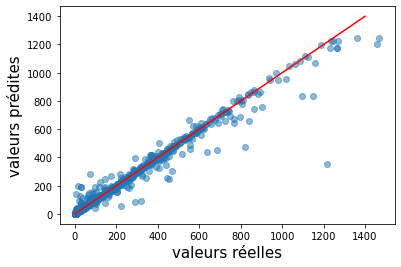

In [157]:
y_pred = cross_val_predict(best_model, X_train_prepared, y_train, cv=5)
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot(np.linspace(0, 1_400), np.linspace(0, 1_400), c='red')
plt.xlabel("valeurs réelles", fontsize=15)
plt.ylabel("valeurs prédites", fontsize=15)
plt.show()

In [187]:
feature_importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame(
    sorted(zip(feature_importances, range(len(feature_importances))), reverse=True),
    columns=['MDI', 'variable']
    )
feature_imp_df

,MDI,variable
0,0.596203,0
1,0.296153,1
2,0.085071,4
3,0.007762,5
4,0.005451,2
5,0.004190,7
6,0.002638,6
7,0.002532,3
